# Radio playlists analysis

In this project, we investigated playlists from Swiss radios over the past few years.

First, we wrote scrapers for the following Swiss radios, that extract a song's name, its performer, and the date at which it was played:

* La 1ère
* Espace 2
* Couleur 3
* Option Musique
* Rouge FM

This gives us a fairly large panel of music choices.

The scrapers themselves are not always easy to write, especially because the radios have (undocumented) limits on how much one may scrape per hour/day/...; while the end result is code that is fairly readable, their development took some time. Their code can be found in the `scrapers` folder.

We originally wanted to do OneFM as well, but because of the time limit scraping is *slower* than the rate at which they play songs; in other words, it's impossible to scrape all of their data because they're adding it faster than it comes out of the scraper!

Some other radios we tried don't even have a way to scrape more than the most recently played songs, which is useless for our purposes.

The raw scraped playlists are in the `data/raw-playlists` folder.

Let's have a quick look at one of the files:

In [2]:
import pandas as pd

pd.read_csv("data/raw-playlists/option-musique", sep="\x1f", header=None, names=["date", "track", "artist"]).head()

,date,track,artist
0,2017-01-05 00:03:06,Encore une fois,Catherine Lara
1,2017-01-05 00:08:00,Je t'aime...moi non plus,Serge Gainsbourg/ Jane Birkin
2,2017-01-05 00:12:23,Please forgive me,Bryan Adams
3,2017-01-05 00:16:56,Comme un brasero,Pierre Rapsat
4,2017-01-05 00:21:17,L'esprit grande prairie,Eddy Mitchell


From this short overview, one can already notice an unfortunate but important fact: names must be normalized.

Indeed, *Serge Gainsbourg/ Jane Birkin* is not one single artist, but two different people. And in this case, they're separated in a slightly odd way since there's a space only in one side of the separator. Clearly, we must deal with this kind of problems, to avoid duplicates and failed metadata searches later.

We will, of course, encounter false positives; for instance, *Ike & Tina Turner* were a duo that always sang together, hence it does not make sense to split them. But these should be rare enough; if we see too many bad things, we can always hardcode the most frequent ones.

## Tags

We used last.fm's API to get tags. This API has the peculiarity that all tags are user-submitted, which means some care is needed to filter out the weird ones.

In [2]:
import json
import urllib.parse
import urllib.request

def top_tags(artist, track):
    url = "http://ws.audioscrobbler.com/2.0/?method=track.gettoptags" \
          "&artist={a}" \
          "&track={t}" \
          "&api_key=OUR_API_KEY_HERE" \
          "&format=json"
    url = url.format(a=urllib.parse.quote(artist), t=urllib.parse.quote(track))
        
    req = urllib.request.urlopen(url)
    obj = json.loads(req.read().decode("utf-8"))
    
    try:
        return [tag["name"] for tag in obj["toptags"]["tag"] if int(tag["count"]) >= 10]
    except KeyError:
        return []

In [86]:
top_tags("the drums", "money")

['indie',
 'indie pop',
 'indie rock',
 'surf rock',
 'alternative',
 'summer',
 'alternative rock',
 'post-punk',
 'rock',
 'american',
 'Post punk',
 'best song ever',
 '010s',
 'snowlist']

We got tags for all songs, and put them in `data/tagged-playlists`.

In [1]:
import pandas as pd

tagged = pd.read_csv("data/tagged-playlists/option-musique", 
                     sep="\x1f", header=None, names=["date", "track", "artist", "tags"])
tagged = tagged.fillna("")
tagged["tags"] = tagged["tags"].str.split("\x1e")
tagged.head()

,date,track,artist,tags
0,2017-01-05 00:03:06,Encore Une Fois,Catherine Lara,"[new age, french, electronic, instrumental, wo..."
1,2017-01-05 00:08:00,Je t'aime...moi non plus,Serge Gainsbourg/ Jane Birkin,[]
2,2017-01-05 00:12:23,Please Forgive Me,Bryan Adams,"[rock, Ballad, bryan adams, romantic, Love, cl..."
3,2017-01-05 00:16:56,Comme un brasero,Pierre Rapsat,"[chanson francaise, french, Belgium, belgian, ..."
4,2017-01-05 00:21:17,L'Esprit Grande Prairie,Eddy Mitchell,"[Chanson Française, live]"


## Normalization

Let's normalize artist names a bit and split them...

We ignore anything in parentheses.

In [63]:
def normalize_name(name):
    name = str(name)
    
    open_paren = 0
    result = ""
    for c in name:
        if c == '(':
            open_paren += 1
        elif c == ')':
            open_paren -= 1
        elif open_paren == 0:
            result += c
    return result.strip().lower()

In [64]:
normalize_name("(REP) Lost Boy & Suicide Girl (feat. Simon Jäggi)")

'lost boy & suicide girl'

In [73]:
import re

def split_artist(artist):
    artist = str(artist)
    
    # this causes a few false positives, e.g. "Ike & Tina Turner"
    # NOT "," otherwise a ton of artists are misidentified...
    return [normalize_name(a) for a in re.split("&| x |/|feat.", artist)]

In [66]:
split_artist("Queen/ David Bowie")

['queen', 'david bowie']

## Tags filtering

We also got each tag and its popularity (in number of songs) per radio:

In [2]:
pd.set_option('max_colwidth', 80)

tags = pd.read_csv("data/tagpop/couleur3", sep="\x1f", encoding="latin1")
tags.head()

,tag,count
0,indie,136550.0
1,rock,119772.0
2,alternative,117967.0
3,electronic,109965.0
4,pop,100001.0


Unfortunately, a significant amount of tags are:
- Complete nonsense (`homoerotic arabian sex soundtrack with guest vocalist satan`)
- Irrelevant (`macbook air`)
- Useless (`all`)
- Personal opinions (`2nd favorite`)
- Personal opinions of the dubious kind (`as nice as her butt`)
- Insults (`only cocksuckers can listen to this shit`)
- Godwin points (`adolf hitler cover`)
- Artist names (`enrico macias`)
- Artist names, misspelled, often because of a lack of punctuation or spacing (`israel kamakawiwoole`)
- Artist names, misspelled so badly there is no hope (`qorndydye quorn`)
- Song names (`mon pere`)
- Artist and song names (`serge gainsbourg-je taime moi non plus`)

Worse, there is not much correlation between popularity and meaningfulness of a tag. Even the most popular tags contain useless information.

We therefore decided to keep all tags, but do "top N" queries when we will use them.

Now we can dump all of that as a single CSVs, with radio names, normalized song names artist names, split artists, and tags!

In [74]:
import pandas as pd

frames = []

for radio in ["la-1ere", "espace2", "couleur3", "option-musique", "rougefm"]:
    print("Processing: " + radio)
    songs = pd.read_csv("data/raw-playlists/" + radio, 
                        sep="\x1f", 
                        header=None, 
                        names=["date", "track", "artists"])    
    tagged = pd.read_csv("data/tagged-playlists/" + radio, 
                        sep="\x1f", 
                        header=None, 
                        names=["date", "track", "artists", "tags"]).drop_duplicates(["date"])
    tagged["tags"] = tagged["tags"].str.split("\x1e")
    
    songs = songs.join(tagged.set_index(["track", "artists"]), 
                       on=["track", "artists"], rsuffix="_ignored").drop(["date_ignored"], axis=1)
    
    songs = songs.fillna("")
    
    songs["date"] = pd.to_datetime(songs["date"], format="%Y-%m-%d %H:%M:%S")
    songs = songs.set_index("date")
    songs = songs.sort_index()
    # Magic from http://stackoverflow.com/a/40339749/3311770 to avoid "NaT", aka "Not a Time"
    songs["TMP"] = songs.index.values         # index is a DateTimeIndex
    songs = songs[songs.TMP.notnull()]        # remove all NaT values
    songs.drop(["TMP"], axis=1, inplace=True) # delete TMP again

    songs["radio"] = radio
    
    songs["track"] = songs["track"].apply(normalize_name)
    
    songs["artists"] = songs["artists"].apply(split_artist)
    
    
    frames.append(songs)

result = pd.concat(frames)
result.sample(n=10)

Processing: la-1ere
Processing: espace2
Processing: couleur3
Processing: option-musique
Processing: rougefm


,track,artists,tags,radio
date,,,,
2014-08-06 22:45:00,grace,[jeff buckley],"[rock, singer-songwriter, alternative rock, in...",la-1ere
2012-03-13 05:44:00,bye bye,[la grande sophie],,couleur3
2016-07-11 20:01:00,america,[razorlight],"[indie, indie rock, rock, british, alternative...",rougefm
2013-10-03 11:26:53,rouge ardent,[axelle red],"[chanson, magical, Belgisch, dreamy female pop...",option-musique
2012-01-25 22:07:48,de temps en temps,[grégory lemarchal],,option-musique
2016-09-18 21:26:16,tu peux préparer le café noir,[eddy mitchell],,option-musique
2016-09-29 21:47:44,l'amour naissant,[sebastien tellier],,la-1ere
2015-04-29 08:52:02,petite soeur,[ben l'oncle soul],,option-musique
2015-08-10 17:52:00,i lived,[one republic],,rougefm


In [75]:
result.to_pickle("data/full-frame")

## Visualizations and queries!

Now that we've scraped our data, normalized it, and gotten tags out of it, let's do stuff!

In [1]:
import pandas as pd

# don't forget to unzip it if needed
songs = pd.read_pickle("data/full-frame")
songs.head()

,track,artists,tags,radio
date,,,,
2011-10-21 00:05:00,valse pour piano. eglantine: valse,[xaver scharwenka],,la-1ere
2011-10-21 00:10:00,big boss and his gang,[peter thomas sound orchestra],,la-1ere
2011-10-21 00:15:00,ce qu'on entend sur la montagne. poème symphon...,[franz liszt],,la-1ere
2011-10-21 00:20:00,the train stops,[georges delerue],,la-1ere
2011-10-21 00:25:00,"quatuor à cordes no 5, en mi bémol majeur: 2. ...",[felix mendelssohn],,la-1ere


### Amount of songs per radio

First question: Do some radios play significantly more songs than others, normalized over a day?

In [22]:
from datetime import datetime

for (radio, radio_songs) in songs.groupby("radio"):
     # this will round, but there are enough days for it not to be significant
    total_days = (radio_songs.index.max() - radio_songs.index.min()).days
    
    print(radio + ": " + str(radio_songs.shape[0]) + " songs in " + 
          str(total_days) + " days; ratio = " + str(round(radio_songs.shape[0] / total_days, 0)))

couleur3: 610654 songs in 1906 days; ratio = 320.0
espace2: 196306 songs in 1907 days; ratio = 103.0
la-1ere: 160981 songs in 1903 days; ratio = 85.0
option-musique: 643439 songs in 1905 days; ratio = 338.0
rougefm: 164144 songs in 661 days; ratio = 248.0


There are two clear packs: `Option Musique`, `Couleur 3` and `Rouge FM` are very clearly above the others at about 300 songs a day, while `Espace 2` and `La 1ère` end the pack with only 100 songs a day.

This data can be explained by what those radios do.

* `Option Musique`, `Couleur 3` and `Rouge FM` are pop radios with very little commentary, hence many short songs.
* `Espace 2` is a classical music radio, thus the songs (sonatas, fugues, ...) are much longer than pop songs.
* `La 1ère` is not primarily a music radio, thus it doesn't have many songs.

### Number of different songs

Do radio planners have some imagination?

In [27]:
for (radio, radio_songs) in songs.groupby("radio"):
    songs_only = radio_songs[radio_songs["track"] != "info trois"]["track"] # couleur 3..
    print(songs_only.value_counts().apply(lambda x: (1 - x) ** 2).sum())
    total_count = songs_only.size
    uniq_count = songs_only.unique().size
    
    print(radio + ": " + str(total_count) + " songs, of which " 
          + str(uniq_count) + " are unique = " + str(round(uniq_count / total_count * 100, 2)) + "%")

103911617
couleur3: 604492 songs, of which 38389 are unique = 6.35%
1059310
espace2: 196306 songs, of which 106846 are unique = 54.43%
5176366
la-1ere: 160981 songs, of which 29801 are unique = 18.51%
182794474
option-musique: 643439 songs, of which 6219 are unique = 0.97%
61987718
rougefm: 164144 songs, of which 1822 are unique = 1.11%


The results are interesting, and could be a way to decide which radio to listen to. Clearly, if one wants to discover new songs, `Option Musique` is not the way to go with less than 1% unique songs. `Rouge FM` is almost as bad.

### Number of different songs per artist

Another interesting measure: Do radios only ever broadcast the same few songs of each artist?

In [16]:
import numpy

for (radio, radio_songs) in songs.groupby("radio"):
    songs_only = radio_songs.reset_index().drop(["date", "tags", "radio"], axis=1)
    songs_only["artists"] = songs_only["artists"].apply(lambda x: ', '.join(x))
    
    total_artists = 0
    uniq_by_artist = []
    for (artist, by_artist) in songs_only.groupby("artists"):
        total_artists = total_artists + 1
        uniq_by_artist.append(by_artist["track"].unique().size)
    
    uniq_count = numpy.mean(uniq_by_artist)
    
    print(radio + ": " + str(total_artists) + " artists, with " 
          + str(round(uniq_count, 1)) + " mean unique songs per artist")

couleur3: 19277 artists, with 2.4 mean unique songs per artist
espace2: 14934 artists, with 7.6 mean unique songs per artist
la-1ere: 13055 artists, with 2.8 mean unique songs per artist
option-musique: 2567 artists, with 2.8 mean unique songs per artist
rougefm: 1104 artists, with 1.8 mean unique songs per artist


It's official, `Rouge FM` is the worst radio ever. :)

### Songs with many covers

Which songs have covers that are popular on radios?

In [17]:
by_track = songs[songs["radio"] != "espace2"]
by_track = by_track.reset_index().drop(["date", "tags", "radio"], axis=1)
by_track["artists"] = by_track["artists"].apply(lambda x: ', '.join(x)) # otherwise drop_duplicates fails
by_track = by_track.drop_duplicates()

by_track.groupby("track") \
        .size() \
        .order(ascending=False) \
        .head(50)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)


track
home                    34
summertime              31
fire                    24
fever                   24
money                   23
bang bang               20
trouble                 20
revolution              20
untitled                20
free                    20
hold on                 20
crazy                   19
time                    18
love                    18
shine                   18
smile                   18
hallelujah              17
you                     17
paris                   17
hello                   17
paradise                17
i want you              17
main title              17
america                 16
the end                 16
breathe                 15
work                    15
i put a spell on you    15
wake up                 15
desire                  15
together                15
stay                    15
freedom                 15
rise                    14
easy                    14
ain't no sunshine       14
la vie en rose        

### When are songs played?

Are famous songs played more at certain times?

In [40]:
from datetime import datetime, timedelta

timed = songs.drop(["tags", "artists", "radio"], axis=1).reset_index()
timed["date"] = timed["date"].apply(lambda x: x.time().hour)

popularity = songs["track"].value_counts().to_dict()

avgs = {}
for (hour, by_hour) in timed.groupby("date"):
    avgs[hour] = by_hour["track"].apply(lambda t: popularity[t]).mean()

print(avgs)

{0: 346.53695354784986, 1: 213.68699633438405, 2: 236.4965720732448, 3: 233.46770976102917, 4: 231.3344446414849, 5: 258.61345741693697, 6: 241.79672281425462, 7: 255.67255734681902, 8: 270.2272084351292, 9: 277.0992515457208, 10: 270.0772846751874, 11: 266.93390043834904, 12: 268.16952762413376, 13: 259.747941435491, 14: 227.2854030269535, 15: 233.01356131421664, 16: 273.2408305949801, 17: 245.53675308589246, 18: 255.57913321153876, 19: 259.82799237005247, 20: 261.8825718992467, 21: 288.71881885632916, 22: 265.23398044291054, 23: 291.3940444304396}


Populating the interactive namespace from numpy and matplotlib


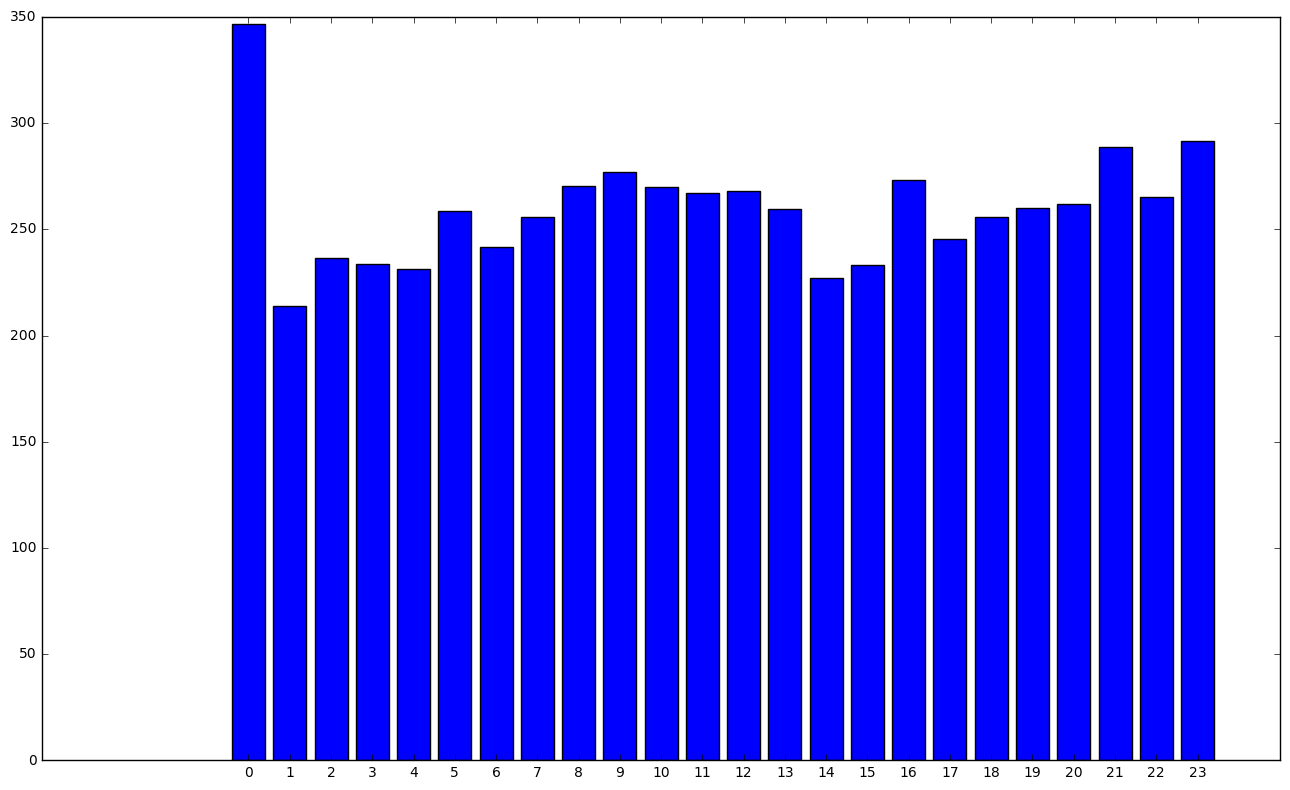

In [50]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 8)

import matplotlib.pyplot as plt

plt.bar(range(len(avgs)), avgs.values(), align='center')
plt.xticks(range(len(avgs)), list(avgs.keys()))
plt.tight_layout()

plt.show()

### Artists with the most collaborators

Which artists have made popular songs with the most people?

In [2]:
coops = songs.reset_index().drop(["date", "tags"], axis=1).drop_duplicates(["track"])
coops = coops[coops["artists"].apply(lambda x: len(x) > 1)]

collaborators_by_artist = {}
excludes = set(["memb.", "cie", "s", "d", "t", "g", "r", "a", "o", "u", ""])
for coop in coops.iterrows():
    all_artists = set(coop[1]["artists"]).difference(excludes)
    for artist in all_artists:
        if artist not in collaborators_by_artist:
            collaborators_by_artist[artist] = set()
        for other in all_artists.difference(set([artist])):
            collaborators_by_artist[artist].add(other)
        
top_collabs = sorted(collaborators_by_artist, key=lambda k: len(collaborators_by_artist[k]), reverse=True)[:20]
for collab in top_collabs:
    print(collab + "(" + str(len(collaborators_by_artist[collab])) + "): " + ", ".join(collaborators_by_artist[collab]))

kanye west(10): travis$ scott, mos def freeway, twista, paul mccartney, jay-z, peace treaty vs empire of the sun vs jay z, rihanna, jamie foxx, clipse, j dilla
jean-michel jarre(10): pete townshend, yello, bruce keen, rone, little boots, bruno mylonas, moby, edward snowden, boys noize, the orb
snoop dogg(10): katy perry, dr. dre, will i am, wiz khalifa, jon connor, raekwon, pharrell, r. kelly, steve wonder, tara mcdonald
nick cave(9): waren ellis, debbie harry, warren ellis, bad seeds, ellis warren, pj harvey, the bad seeds, warren ellis |, kylie minogue
skrillex(9): they., zhu, vic mensa, alvin risk, kaskade, the doors, damian marley, elliphant, jauz
david byrne(8): jun miyake, the bpa, dizzee rascal, santigold, brian eno, de la soul, fatboyslim, st. vincent
usher(8): martin garrix, will i am, alicia keys, p diddy, ludacris, juicy j, loon, pitbull
benjamin biolay(8): chiara mastroianni, jeanne cherhal, po, vanessa paradis, emmanuelle devos, alika, henri salvador, daphné
a-trak(8): zhu

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


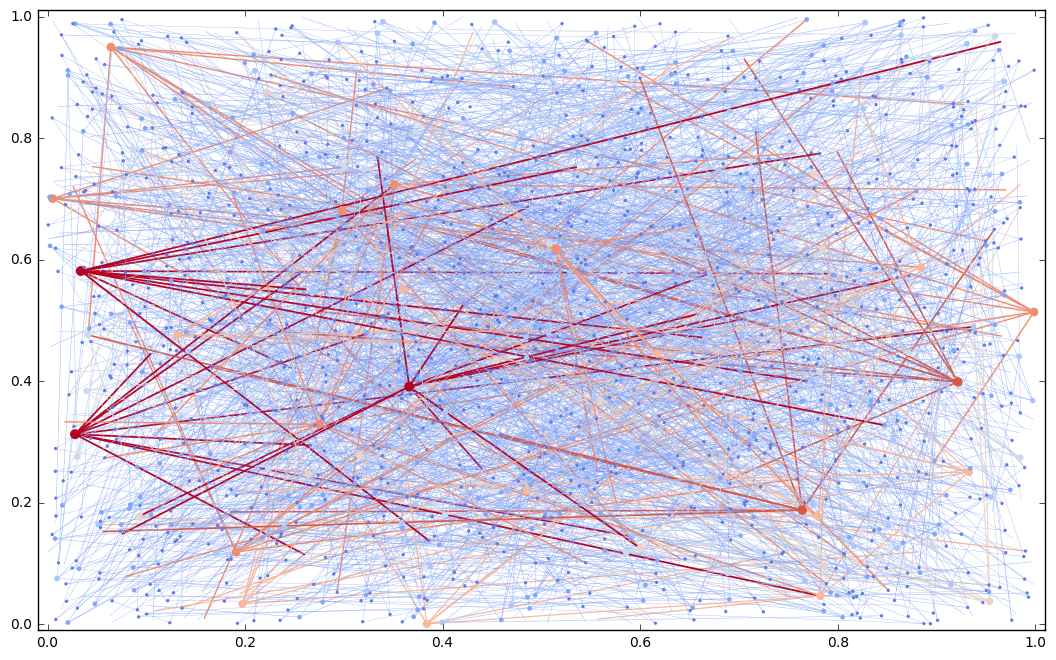

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 8)

import networkx as nx
import matplotlib.pyplot as plt
import random

minincl = 1

def get_color(k):
    vs = collaborators_by_artist[k]
    return ((len(vs) - minincl) ** 1.0) / (7.0 ** 1.0)


sorted_collabs = sorted(collaborators_by_artist, key=lambda k: len(collaborators_by_artist[k]), reverse=True)

G = nx.Graph()
for k in sorted_collabs:
    if len(collaborators_by_artist[k]) >= minincl:
        G.add_node(k, color=get_color(k))
    
for k in sorted_collabs:
    for v in collaborators_by_artist[k]:
        if G.has_node(k) and G.has_node(v) and not G.has_edge(k,v):
            color = max(get_color(k), get_color(v))
            G.add_edge(k,v, color=color)

colors = [d["color"] for (n, d) in G.nodes_iter(data=True)]
sizes = [c * 40.0 for c in colors]
edge_colors = [d["color"] for (n1, n2, d) in G.edges_iter(data=True)]

cmap = plt.get_cmap("coolwarm")
pos = nx.random_layout(G)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=cmap, width=edge_colors)
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cmap, node_size=sizes, linewidths=0)

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

### Rick Rolling

Not quite what we expected:

In [82]:
songs[songs["track"] == "never gonna give you up"]

,track,artists,tags,radio
date,,,,
2013-09-30 02:55:00,never gonna give you up,[the black keys],"[blues rock, rock, blues, soul, indie rock, co...",couleur3
2013-09-30 02:55:00,never gonna give you up,[the black keys],"[blues rock, rock, blues, soul, indie rock, co...",couleur3
2014-01-15 17:06:00,never gonna give you up,[the black keys],"[blues rock, rock, blues, soul, indie rock, co...",couleur3
2014-01-15 17:06:00,never gonna give you up,[the black keys],"[blues rock, rock, blues, soul, indie rock, co...",couleur3
2014-03-05 14:57:00,never gonna give you up,[the black keys],"[blues rock, rock, blues, soul, indie rock, co...",couleur3
2014-03-05 14:57:00,never gonna give you up,[the black keys],"[blues rock, rock, blues, soul, indie rock, co...",couleur3
2016-09-12 06:44:00,never gonna give you up,[rick astley],"[80s, pop, Brutal Death Metal, rickroll, RICKR...",rougefm


### What's Harry Belafonte famous for?

...not that...

In [86]:
songs[songs["artists"].apply(lambda k: "harry belafonte" in k)]["track"].value_counts()

the twelve days of christmas    34
try to remember                  6
island in the sun                4
matilda                          3
jump in the line                 3
cocoanut woman                   2
banana boat song                 2
day-o                            2
banana boat                      1
coconut woman                    1
Name: track, dtype: int64

In [28]:
famous_translations = [
    # Dave
    ("vanina", "runaway", "del shannon"),
    # Johnny Hallyday
    ("le pénitencier", "house of the rising sun", None),
    # Eddy Mitchell
    ("a crédit et en stéréo", "no particular place to go", None),
    ("pas de boogie woogie", "don't boogie woogie", None),
    ("sur la route de memphis", "that's how i got to memphis", None),
    # Francoise Hardy
    ("la maison où j'ai grandi", "il ragazzo della via gluck", None)
]

for t in famous_translations:
    trans_count = songs[songs["track"] == t[0]].shape[0]
    orig_count = songs[(songs["track"] == t[1]) & (songs["artists"].apply(lambda a: t[2] is None or t[2] in a))].shape[0]
    
    print(t[0] + ": " + str(trans_count));
    print(t[1] + ": " + str(orig_count));
    print("---")

vanina: 423
runaway: 6
---
le pénitencier: 100
house of the rising sun: 30
---
noir c'est noir: 1
black is black: 2
---
a crédit et en stéréo: 321
no particular place to go: 0
---
pas de boogie woogie: 297
don't boogie woogie: 0
---
sur la route de memphis: 359
that's how i got to memphis: 3
---
la maison où j'ai grandi: 994
il ragazzo della via gluck: 8
---


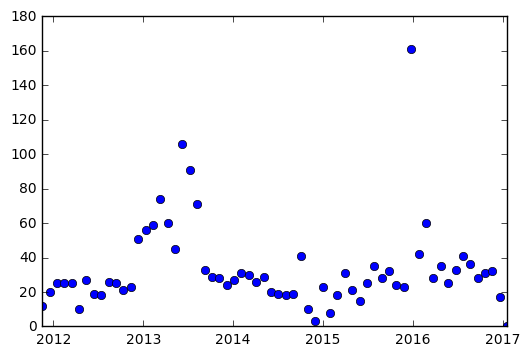

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as dts
from datetime import timedelta
%matplotlib inline

dates = songs[songs["artists"].apply(lambda t: "david bowie" in t)].reset_index()["date"].tolist()
dates = [d.date() for d in dates]
min_date = min(dates)
max_date = max(dates)
x = []
y = []
#python's dates are retarded, no months...
while min_date < max_date:
    min_date = min_date + timedelta(30)
    next_date = min_date + timedelta(30)
    x.append(min_date)
    
    y.append(len([d for d in dates if min_date < d and d < next_date]))

plt.plot_date(x, y)

### Most popular tag per month

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as dts
from datetime import timedelta
%matplotlib inline

alltags = songs[songs["tags"].apply(lambda t: type(t) == type([]))]["tags"]
alltags = alltags.sort_index()
dates = songs[songs["artists"].apply(lambda t: "david bowie" in t)].reset_index()["date"].tolist()
dates = [d.date() for d in dates]
min_date = min(dates)
max_date = max(dates) - timedelta(30)
x = []
y = []
#python's dates are retarded, no months...
while min_date < max_date:
    prev_date = min_date
    min_date = min_date + timedelta(30)
    next_date = min_date + timedelta(30)
    nextnext_date = next_date + timedelta(30)
    print(".", end="")
    prev_tags = pd.Series(alltags[prev_date:min_date].sum()).value_counts()[:50].to_dict()
    month_tags = pd.Series(alltags[min_date:next_date].sum()).value_counts()[:50].to_dict()
    next_tags = pd.Series(alltags[next_date:nextnext_date].sum()).value_counts()[:50].to_dict()
    pop_tags = [k for (k,v) in month_tags.items() if v > 100 and v > 3 * prev_tags.get(k, 0) and v > 3 * next_tags.get(k, 0)]

    x.append(min_date)
    y.append(pop_tags)

for n in range(len(x)):
    print(str(x[n]) + ": " + str(", ".join(y[n])))

...............................................................2011-11-17: best of 2011
2011-12-17: 
2012-01-16: piano
2012-02-15: funk
2012-03-16: 
2012-04-15: funk, dub
2012-05-15: Love
2012-06-14: piano, funk, 2011
2012-07-14: downtempo, chill
2012-08-13: 
2012-09-12: 
2012-10-12: 90s, baroque
2012-11-11: 60s, francophone, funk, chillout
2012-12-11: Canadian, 2011, 2012 single
2013-01-10: easy listening, best of 2012, chillout
2013-02-09: experimental
2013-03-11: 
2013-04-10: oldies
2013-05-10: 
2013-06-09: Awesome
2013-07-09: 2010s
2013-08-08: synthpop, composer, acoustic
2013-09-07: House
2013-10-07: acoustic
2013-11-06: personal favourites
2013-12-06: 
2014-01-05: electronica, Soundtrack
2014-02-04: classic rock
2014-03-06: 
2014-04-05: electronica, hip hop
2014-05-05: 90s
2014-06-04: 
2014-07-04: 
2014-08-03: love at first listen
2014-09-02: 
2014-10-02: swiss
2014-11-01: 
2014-12-01: funk
2014-12-31: love at first listen
2015-01-30: german
2015-03-01: female vocalist
2015-03-31

In [14]:
songs[songs["artists"].apply(lambda k: "ada" in k)]

,track,artists,tags,radio
date,,,,
2012-11-17 00:50:00,lovestoned,[ada],"[tech house, melodic, female vocals, futuristi...",couleur3
2012-11-17 00:50:00,lovestoned,[ada],"[tech house, melodic, female vocals, futuristi...",couleur3
2012-11-25 00:50:00,lovestoned,[ada],"[tech house, melodic, female vocals, futuristi...",couleur3
2012-11-25 00:50:00,lovestoned,[ada],"[tech house, melodic, female vocals, futuristi...",couleur3
2015-07-23 08:13:41,la vendetta di nino,"[ada, ferri]",,espace2
2016-10-21 23:50:00,lovestoned,[ada],,couleur3


In [5]:
maxlen = 0
maxtag = ""

for (date, song) in songs.iterrows():
    if len(song.tags) > 0:
        for tag in song.tags:
            if len(tag) > maxlen:
                maxtag = tag
                maxlen = len(tag)

print(maxtag)

best shit ever existing in the whole world makes me vomit over my daddys pussy while i listen to the popes earcream following the dark lord to my grandmummies treassure in an iland of dicksucking faggot frogs having silver eyebrows


In [28]:
songs[songs["track"] == "il ragazzo della via gluck"]

,track,artists,tags,radio
date,,,,
2014-01-13 10:25:54,il ragazzo della via gluck,[adriano celentano],"[italian, Adriano Celentano, Il Ragazzo della ...",la-1ere
2014-01-13 10:25:54,il ragazzo della via gluck,[adriano celentano],"[italian, Adriano Celentano, Il Ragazzo della ...",la-1ere
2014-05-28 10:43:35,il ragazzo della via gluck,[adriano celentano],"[italian, Adriano Celentano, Il Ragazzo della ...",la-1ere
2014-05-28 10:43:35,il ragazzo della via gluck,[adriano celentano],"[italian, Adriano Celentano, Il Ragazzo della ...",la-1ere
2014-07-27 06:30:00,il ragazzo della via gluck,[adriano celentano],,la-1ere
2014-10-19 06:32:12,il ragazzo della via gluck,[adriano celentano],,la-1ere
2016-02-27 05:56:47,il ragazzo della via gluck,[adriano celentano],,la-1ere
2016-12-18 21:47:52,il ragazzo della via gluck,[adriano celentano],,option-musique
